In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/abhivansh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
np.random.seed(42)
num_samples = 1000
x_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))
t_train = np.random.uniform(low=0, high=1, size=(num_samples, 1))
u_exact = np.sin(np.pi * x_train) * np.exp(-np.pi**2 * t_train)

x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_train_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
u_exact_tf = tf.convert_to_tensor(u_exact, dtype=tf.float32)

input_train = tf.concat([x_train_tf, t_train_tf], axis=1)

x_test = np.linspace(0, 1, 100).reshape(-1, 1)
t_test = np.linspace(0, 1, 100).reshape(-1, 1)

x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
t_test_tf = tf.convert_to_tensor(t_test, dtype=tf.float32)

input_test = tf.concat([x_test_tf, t_test_tf], axis=1)

u_exact_test = np.sin(np.pi * x_test) * np.exp(-np.pi**2 * t_test)
u_exact_test_tf = tf.convert_to_tensor(u_exact_test, dtype=tf.float32)

In [15]:
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(50, activation='tanh', input_dim=2)
        self.dense2 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(50, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = inputs[:, 0:1]
        t = inputs[:, 1:2]
        concat_input = tf.concat([x, t], axis=1)
        hidden1 = self.dense1(concat_input)
        hidden2 = self.dense2(hidden1)
        hidden3 = self.dense3(hidden2) 
        hidden4 = self.dense4(hidden3)  
        output = self.output_layer(hidden4)
        return output

def physics_loss(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        u_pred = model(tf.concat([x, t], axis=1))
        u_x = tape.gradient(u_pred, x)
        u_xx = tape.gradient(u_x, x)
        u_t = tape.gradient(u_pred, t)
        del tape

    alpha = 0.01  

    pde_loss = u_t - alpha * u_xx

    return tf.reduce_mean(tf.square(pde_loss))


model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

num_epochs = 2000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        physics_loss_value = physics_loss(model, x_train_tf, t_train_tf)
        data_loss_value = tf.reduce_mean(tf.square(model(input_train) - u_exact_tf))
        total_loss = physics_loss_value + data_loss_value
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Total Loss: {total_loss.numpy()}, Physics Loss: {physics_loss_value.numpy()}, Data Loss: {data_loss_value.numpy()}")
u_pred=model(input_test)

Epoch 0/2000, Total Loss: 0.05924580618739128, Physics Loss: 0.030938301235437393, Data Loss: 0.028307504951953888
Epoch 100/2000, Total Loss: 0.02003990113735199, Physics Loss: 0.000745100958738476, Data Loss: 0.019294800236821175
Epoch 200/2000, Total Loss: 0.018947793170809746, Physics Loss: 0.0007069113198667765, Data Loss: 0.018240882083773613
Epoch 300/2000, Total Loss: 0.01873338408768177, Physics Loss: 0.0007781751337461174, Data Loss: 0.01795520819723606
Epoch 400/2000, Total Loss: 0.018708599731326103, Physics Loss: 0.000836028775665909, Data Loss: 0.01787257008254528
Epoch 500/2000, Total Loss: 0.018695024773478508, Physics Loss: 0.0008509783656336367, Data Loss: 0.017844045534729958
Epoch 600/2000, Total Loss: 0.018681935966014862, Physics Loss: 0.0008545425371266901, Data Loss: 0.017827393487095833
Epoch 700/2000, Total Loss: 0.018668053671717644, Physics Loss: 0.0008573601371608675, Data Loss: 0.017810693010687828
Epoch 800/2000, Total Loss: 0.018652770668268204, Physics 

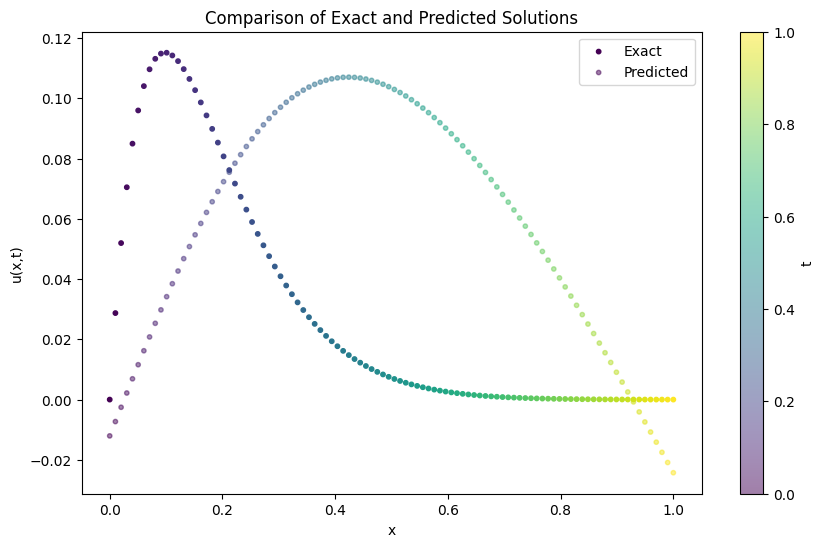

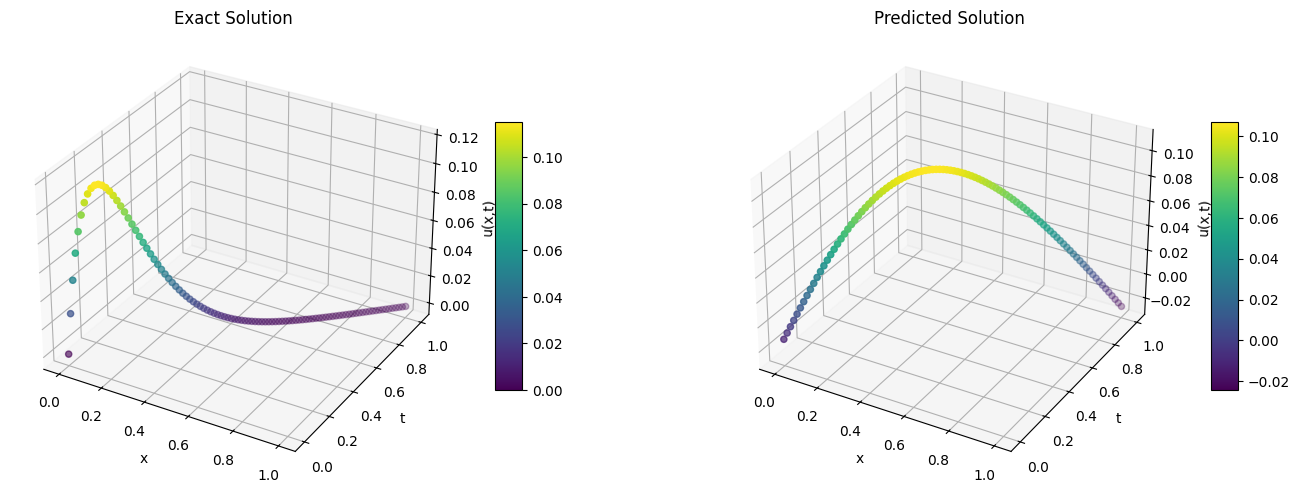

Mean Squared Error: 0.004173105911178527


In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_plot = x_test.flatten()
t_plot = t_test.flatten()
u_exact_plot = u_exact_test.flatten()
u_pred_plot = u_pred.numpy().flatten()

plt.figure(figsize=(10, 6))
plt.scatter(x_plot, u_exact_plot, c=t_plot, cmap='viridis', s=10, label='Exact')
plt.scatter(x_plot, u_pred_plot, c=t_plot, cmap='viridis', s=10, alpha=0.5, label='Predicted')
plt.colorbar(label='t')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Exact and Predicted Solutions')
plt.legend()
plt.show()

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(x_plot, t_plot, u_exact_plot, c=u_exact_plot, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('u(x,t)')
ax1.set_title('Exact Solution')
fig.colorbar(scatter1, ax=ax1, shrink=0.6, aspect=10)

ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(x_plot, t_plot, u_pred_plot, c=u_pred_plot, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('u(x,t)')
ax2.set_title('Predicted Solution')
fig.colorbar(scatter2, ax=ax2, shrink=0.6, aspect=10)

plt.tight_layout()
plt.show()

mse = np.mean((u_exact_test - u_pred.numpy())**2)
print(f"Mean Squared Error: {mse}")